In [1]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.visualization import ZScaleInterval, ImageNormalize

In [145]:
def create_median_bias(bias_list, median_bias_filename):
    
    #create list for 2D arrays
    bias_list_arrays = [] 

    #for each bias file, trim image and add 2D array to list
    for path in bias_list:
        array = fits.getdata(path)
        bias_list_arrays.append(array) 

    #stack 2D arrays into 3D array
    combine_bias = np.stack(bias_list_arrays) 

    #use sigma clipping to ignore outliers of more than 3-sigma from median for each pixel
    sig_clip = sigma_clip(combine_bias, sigma = 3.0, cenfunc = 'median', axis = 0) 

    #calculate median value and return a 2D array, replace masked values with np.nan
    median_bias = np.ma.median(sig_clip, axis = 0).filled(np.nan)

    #create header
    header = fits.Header()
    header['DATE'] = datetime.now().isoformat() #adds date of when file was created
    header['COMMENT'] = "Combined bias frame from a set of bias images using sigma-clipping to mask outliers" 
    header['NSIGMA'] = 3.0 #sigma-clipping value
    header['NBIAS'] = len(bias_list) #will show how many bias frames were used

    #saves median bias frame as FITS file
    primary = fits.PrimaryHDU(data = median_bias, header = header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite = True)
    
    return median_bias
    

In [3]:
data_dir = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_calibrationdata_5_31/'
bias_files = sorted(pathlib.Path(data_dir).glob("Bias*.fits"))
bias_list = [str(file) for file in bias_files]
bias_file_name = 'median_bias.fits'
bias_output = create_median_bias(bias_list, bias_file_name)

In [4]:
def create_median_dark(dark_list, bias_filename, median_dark_filename):

    #read bias file
    bias_data = fits.getdata(bias_filename) 

    #create list for dark arrays
    dark_list_arrays = [] 
    
    for path in dark_list:
        with fits.open(path) as hdul: #open each dark image
            dark_data = hdul[0].data.astype(np.float32) #give 2D numpy array of data from each file, convert to float32 so code below works
            dark_header = hdul[0].header #open dark header
        dark_data -= bias_data #subtract bias from each dark image
        exposure_time = dark_header['EXPTIME'] #get exposure time from header
        dark_data /= exposure_time #get dark current by dividing each dark image by its exposure time 
        dark_list_arrays.append(dark_data) #add 2D arrays to list created above

    #stack 2D arrays into 3D array
    combine_darks = np.stack(dark_list_arrays) #stack 2D arrays into 3D array

    #use sigma clipping to ignore outliers of more than 3-sigma from median for each pixel
    sig_clip = sigma_clip(combine_darks, sigma = 3.0, cenfunc = 'median', axis = 0)

    #calculate median value and returns a 2D array with the outliers set to NaN (Not a Number)
    median_dark = np.ma.median(sig_clip, axis = 0).filled(np.nan)

    #create header
    header = fits.Header()
    header['DATE'] = datetime.now().isoformat() #add date of when file was created
    header['COMMENT'] = "Combined dark frames using sigma-clipping to mask outliers" 
    header['NSIGMA'] = 3.0 #sigma-clipping value
    header['NDARK'] = len(dark_list) #show how many dark frames were used in header

    #save dark frame as FITS file
    primary = fits.PrimaryHDU(data = median_dark, header = header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_dark_filename, overwrite = True)

    return median_dark

In [5]:
data_dir = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_calibrationdata_5_31/'
dark_files = sorted(pathlib.Path(data_dir).glob("Dark*.fits"))
dark_list = [str(file) for file in dark_files]
dark_file_name = 'median_dark.fits'
dark_output = create_median_dark(dark_list, bias_file_name, dark_file_name)

In [41]:
def create_median_flat(flat_list, bias_filename, median_flat_filename, dark_filename = None):

    #read bias file
    bias_data = fits.getdata(bias_filename) 

    #read dark file if given in argument, does nothing if not
    dark_data = None
    if dark_filename:
        dark_data = fits.getdata(dark_filename)

    #create list to hold 2D arrays
    flat_list_arrays = [] 

    #read filter for first image in flat_list
    with fits.open(flat_list[0]) as hdul:
        reference_filter = hdul[0].header['FILTER'] 
        
    for path in flat_list:
        with fits.open(path) as hdul: #open file
            flat_data = hdul[0].data.astype(np.float32) #gets data from flats
            flat_header = hdul[0].header #gets header for flat image
            flat_filter = flat_header['FILTER'] #reads filter for each flat
            if flat_filter != reference_filter:
                raise ValueError('Filters do not match') #will print error if the filters are not the same
            exposure_time = flat_header.get('EXPTIME') #gets exposure time from each flat header
        
        flat_data -= bias_data #subtracts bias from each flat
        
        if dark_data is not None: 
            flat_data -= dark_data * exposure_time #subtracts scaled dark frame from each flat image if dark is provided
        flat_list_arrays.append(flat_data) #appends flat_data to flat_list_arrays 

    combine_flats = np.stack(flat_list_arrays) #stacks 2D arrays into 3D array
    sig_clip = sigma_clip(combine_flats, sigma = 3.0, cenfunc = 'median', axis = 0) #ignores outliers of more than 3-sigma from median for each pixel

    median_flat = np.ma.median(sig_clip, axis = 0).filled(np.nan) #calculates median value and returns a 2D array with the outliers set to NaN (Not a Number)
    median_flat_normalized = median_flat / np.nanmedian(median_flat) #normalizes median flat by dividing by median pixel value

    #create header
    header = fits.Header() 
    header['CREATOR'] = 'create_median_flat'
    header['DATE'] = datetime.now().isoformat() #adds date of when file was created
    header['COMMENT'] = "Combined flat frames with subtracted bias and optional dark frame subtraction, uses sigma-clipping to mask outliers and divides by median value to normalize" 
    header['NSIGMA'] = 3.0 #sigma-clipping value
    header['NFLAT'] = len(flat_list) #will show how many flat frames were used
    header['FILTER'] = reference_filter #shows filter flats were taken with
    
    primary = fits.PrimaryHDU(data = median_flat_normalized, header = header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_flat_filename, overwrite = True)
    
    #returns normalized median flat as 2D numpy array
    return median_flat_normalized 

In [44]:
data_dir = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_flats_6_4/'
flat_files = sorted(pathlib.Path(data_dir).glob("domeflat_H-Alpha*.fits"))
flat_list = [str(file) for file in flat_files]
flat_file_name = 'median_flat_H-Alpha.fits'
bias_file_name = '/home/jovyan/finalproject/final-project-/code/median_bias.fits'
dark_file_name = '/home/jovyan/finalproject/final-project-/code/median_dark.fits'
flat_output = create_median_flat(flat_list, bias_file_name, flat_file_name, dark_file_name)

In [6]:
def reduce_science_frame(science_filename, median_bias_filename, median_flat_filename, median_dark_filename,
    reduced_science_filename = "reduced_science.fits"):

    #read bias, flat, dark, and science files
    bias_data = fits.getdata(median_bias_filename)
    flat_data = fits.getdata(median_flat_filename)
    dark_data = fits.getdata(median_dark_filename)
    science_data = fits.getdata(science_filename)
    
    #subtract bias 
    science_minusb = science_data - bias_data

    #open science file and get exposure time from header
    with fits.open(science_filename) as hdul:
            exposure_time = hdul[0].header['EXPTIME']

    #subtract dark 
    science_minusd = science_minusb - (dark_data * exposure_time)

    #correct science image with flat frame by dividing by flat
    reduced_science = science_minusd / flat_data

    #create header
    header = fits.Header() 
    header['DATE'] = datetime.now().isoformat() #adds date of when file was created
    header['COMMENT'] = "Science frame with bias and dark frames subtracted, and corrected with flat."

    #save science frame to FITS file
    primary = fits.PrimaryHDU(data = reduced_science, header = header)
    hdul = fits.HDUList([primary])
    hdul.writeto(reduced_science_filename, overwrite = True)

    return reduced_science

In [14]:
science_image = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_sciencedata_5_31/Cat_s Eye Nebula_z_20250601_065953.fits'
flat_file = '/home/jovyan/finalproject/final-project-/code/median_flat_z.fits'
science_file = 'Cats_Eye_z.fits'
reduced_science_image = reduce_science_frame(science_image, bias_file_name, flat_file, dark_file_name,
                         science_file)

In [45]:
def calculate_gain(files):

    #get data from flats
    flat1 = fits.getdata(files[0]).astype('f4')
    flat2 = fits.getdata(files[1]).astype('f4')

    #calculate mean 
    mean1 = np.mean(flat1)
    mean2 = np.mean(flat2)
    mean_combined = (mean1 + mean2) / 2
    
    #calculate the variance of the difference between the flats
    flat_diff = flat1 - flat2
    flat_diff_var = np.var(flat_diff) / 2

    #calculate gain
    gain = mean_combined / flat_diff_var
    
    return gain

In [46]:
flat1 = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_calibrationdata_5_31/domeflat_g_001.fits'
flat2 = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_calibrationdata_5_31/domeflat_g_002.fits'
files = [flat1, flat2]
gain = calculate_gain(files)
print(f"Gain: {gain:.5f} e-/ADU")

Gain: 1.42375 e-/ADU


In [49]:
def calculate_readout_noise(files, gain):

    #get data from both biases
    bias1 = fits.getdata(files[0]).astype(np.float32)
    bias2 = fits.getdata(files[1]).astype(np.float32)
    
    #calculate the variance of the difference between the two biases
    bias_diff = bias1 - bias2
    bias_diff_var = np.var(bias_diff) 

    #calculate the readout noise
    readout_noise_adu = np.sqrt(bias_diff_var / 2)
    readout_noise_e = readout_noise_adu * gain

    return readout_noise_e

In [50]:
bias1 = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_calibrationdata_5_31/Bias_BIN1_20250601_025309.fits'
bias2 = '/home/jovyan/finalproject/final-project-/ARCSAT_data/ARCSAT_data_calibrationdata_5_31/Bias_BIN1_20250601_025324.fits'
files = [bias1, bias2]
readout_noise = calculate_readout_noise(files, gain)
print(f"Readout noise: {readout_noise:.2f} e-")

Readout noise: 17.31 e-


In [69]:
def irg_image(i_image, r_image, g_image):
    
    #read images
    i = fits.getdata(i_image)
    r = fits.getdata(r_image)
    g = fits.getdata(g_image)

    #use astropy visualization package to create Red/Green/Blue color image using i, r, and g filters
    irg = make_lupton_rgb(i, r, g, stretch = 5, Q = 10)

    #crop to zoom in on nebula
    irg_scaled = irg[200:800, 200:900]

    #show and save plot
    plt.imshow(irg_scaled)
    plt.title("Cat's Eye Nebula - IRG Color Image")
    plt.axis('off')
    plt.savefig("irg_color_image.png")
    plt.show()

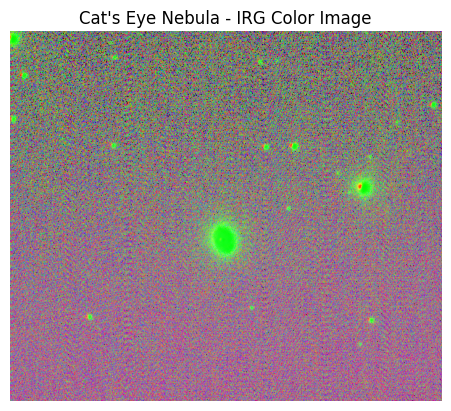

In [70]:
i_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_i.fits'
r_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_r.fits'
g_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_g.fits'
color_image = irg_image(i_path, r_path, g_path)

In [71]:
def zir_image(z_image, i_image, r_image):
    
    #read images
    z = fits.getdata(z_image)
    i = fits.getdata(i_image)
    r = fits.getdata(r_image)

    #use astropy visualization package to create Red/Green/Blue color image using science images in z, i, and r filters
    zir = make_lupton_rgb(z, i, r, stretch = 5, Q = 10)

    #crop to zoom in on nebula
    zir_scaled = zir[200:800, 200:900]

    #show and save plot
    plt.imshow(zir_scaled)
    plt.title("Cat's Eye Nebula - ZIR Color Image")
    plt.axis('off')
    plt.savefig("zir_color_image.png")
    plt.show()

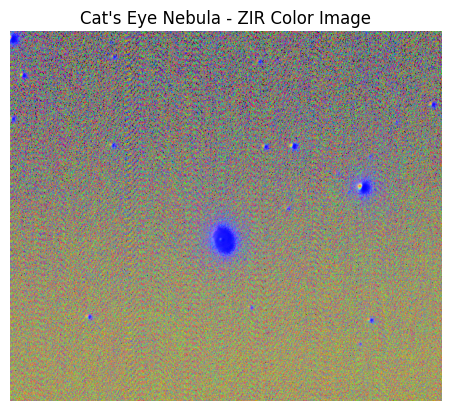

In [72]:
z_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_z.fits'
i_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_i.fits'
r_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_r.fits'
zir_color_image = zir_image(z_path, i_path, r_path)

In [73]:
def ionized_h(science_halpha):

    #get data from H-Alpha science image 
    data = fits.getdata(science_halpha)

    #normalize pixel values
    norm = ImageNormalize(data, interval = ZScaleInterval())

    #show and save figure of H-Alpha emissions
    plt.figure(figsize = (8,8))
    plt.imshow(data, cmap = 'GnBu', origin = 'lower', norm = norm)
    plt.colorbar(label = 'Flux')
    plt.title('Cat\'s Eye Nebula - H-alpha Emission')
    plt.axis('off')
    plt.savefig('H-Alpha_emission_figure.png')
    plt.show()

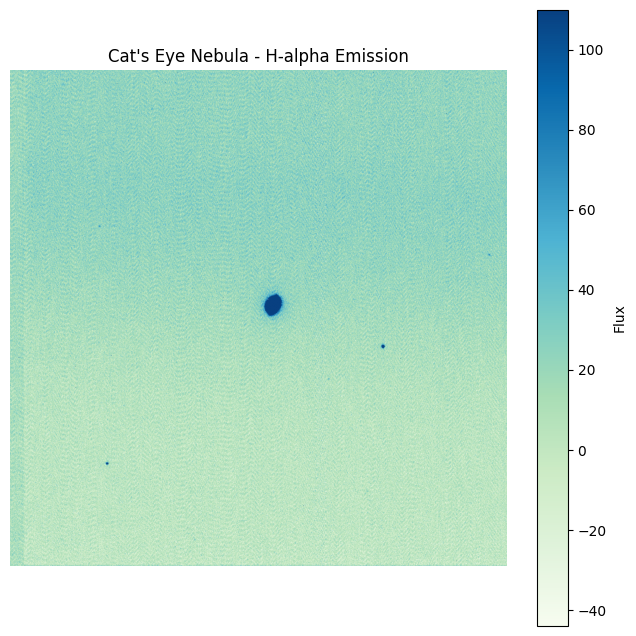

In [74]:
science_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_H-Alpha.fits'
hydrogem = ionized_h(science_path)

In [75]:
def harg_image(halpha_image, r_image, g_image):
    
    #read science images
    ha = fits.getdata(halpha_image)
    r = fits.getdata(r_image)
    g = fits.getdata(g_image)

    #use astropy visualization to create Red/Green/Blue color image from H-Alpha, r, and g science images 
    harg = make_lupton_rgb(ha, r, g, stretch = 3, Q = 10)
    harg_scaled = harg[200:800, 200:900,]

    #show and save plot
    plt.imshow(harg_scaled)
    plt.title("Cat's Eye Nebula - HARG Color Image")
    plt.axis('off')
    plt.savefig("harg_color_image.png")
    plt.show()

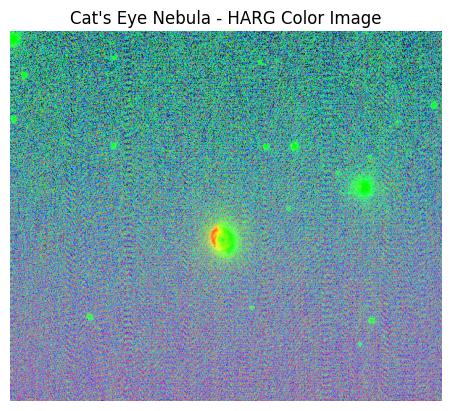

In [76]:
ha_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_H-Alpha.fits'
r_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_r.fits'
g_path = '/home/jovyan/finalproject/final-project-/code/Cats_Eye_g.fits'
harg_color_image = harg_image(ha_path, r_path, g_path)